# Plot temperature response over time

## IRF:
Using forcings from RCMIP models and the impulse response function:
\begin{align*}
\text{IRF}(t)=& 0.885\cdot (\frac{0.587}{4.1}\cdot exp(\frac{-t}{4.1}) + \frac{0.413}{249} \cdot exp(\frac{-t}{249}))\\
\text{IRF}(t)= &  \sum_{i=1}^2\frac{\alpha \cdot c_i}{\tau_i}\cdot exp\big(\frac{-t}{\tau_1}\big) 
\end{align*}
with $\alpha = 0.885$, $c_1=0.587$, $\tau_1=4.1$, $c_2=0.413$ and $\tau_2 = 249$.

IRF.** Hvorfor skriver vi ikke bare $IRF(t) =  \sum_{i=1}^2\alpha_i\cdot exp\big(\frac{-t}{\tau_1}\big)$ 

the estimated ERF$_x$ for some forcing agent $x$ as follows: 

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

The ERFs are taken from models in the RCMIP [https://www.rcmip.org/](https://www.rcmip.org/)

# Data availability:

The data is available on request from [https://gitlab.com/rcmip/rcmip](https://gitlab.com/rcmip/rcmip). 

Please contact: Zebedee Nicholls, email: zebedee.nicholls@climate-energy-college.org

# Code + figures

## Imports:

In [7]:
import xarray as xr
from IPython.display import clear_output
import numpy as np
import os
import re
from pathlib import Path
import pandas as pd
import tqdm
from scmdata import df_append, ScmDataFrame
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from ar6_ch6_rcmipfigs.constants import BASE_DIR
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, INPUT_DATA_DIR

PATH_DATASET = OUTPUT_DATA_DIR + '/forcing_data_rcmip_models.nc'

## IRF:

In [9]:

def IRF(t, l=0.885, alpha1=0.587 / 4.1, alpha2=0.413 / 249, tau1=4.1, tau2=249):
    """
    Returns the IRF function for:
    :param t: Time in years
    :param l: climate sensitivity factor
    :param alpha1:
    :param alpha2:
    :param tau1:
    :param tau2:
    :return:
    IRF
    """
    return l * (alpha1 * np.exp(-t / tau1) + alpha2 * np.exp(-t / tau2))

In [10]:

climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'

## ERF:
Read ERF from file

### Define variables to look at:

In [11]:
# variables to plot:
variables_erf_comp = [
    'Effective Radiative Forcing|Anthropogenic|CH4',
    'Effective Radiative Forcing|Anthropogenic|Aerosols',
    'Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone',
    'Effective Radiative Forcing|Anthropogenic|F-Gases|HFC',
    'Effective Radiative Forcing|Anthropogenic|Other|BC on Snow']
# total ERFs for anthropogenic and total:
variables_erf_tot = ['Effective Radiative Forcing|Anthropogenic',
                     'Effective Radiative Forcing']
# Scenarios to plot:
scenarios_fl = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF-aerchemmip',  # 'ssp370-lowNTCF', Due to mistake here
                'ssp585', 'historical']

## Open dataset:

In [12]:
ds = xr.open_dataset(PATH_DATASET)

# Integrate:
The code below integrates the read in ERFs with the pre defined impulse response function (IRF).

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

In [13]:
name_deltaT = 'Delta T'


def new_varname(var, nname):
    """
    var:str
        Old variable of format varname|bla|bla
    nname:str
        name for the resulting variable, based on var
    Returns
    -------
    new variable name with nname|bla|bla
    """
    return nname + '|' + '|'.join(var.split('|')[1:])


def integrate_(i, var, nvar, ds, ds_DT, csfac=0.885):
    """
    
    Parameters
    ----------
    i:int
        the index for the integral
    var:str
        the name of the EFR variables to integrate
    nvar:str
        the name of output integrated value

    ds:xr.Dataset
        the ds with the intput data
    ds_DT: xr.Dataset
        the ouptut ds with the integrated results
    csfac: climate sensitivity factor (for IRF)
    Returns
    -------
    None
    
    """
    # lets create a ds that goes from 0 to i inclusive
    ds_short = ds[{'time': slice(0, i + 1)}].copy()
    # lets get the current year
    current_year = ds_short['time'][{'time': i}].dt.year
    # lets get a list of years
    years = ds_short['time'].dt.year
    # lets get the year delta until current year(i)
    ds_short['end_year_delta'] = current_year - years

    # lets get the irf values from 0 until i
    ds_short['irf'] = IRF(
        ds_short['end_year_delta'] * ds_short['delta_t'], l=csfac
    )

    # lets do the famous integral
    ds_short['to_integrate'] = \
        ds_short[var] * \
        ds_short['irf'] * \
        ds_short['delta_t']

    # lets sum all the values up until i and set
    # this value at ds_DT
    # If whole array is null, set value to nan
    if np.all(ds_short['to_integrate'].isnull()):  # or last_null:
        _val = np.nan
    else:
        # 

        _ds_int = ds_short['to_integrate'].sum(['time'])
        # mask where last value is null (in order to not get intgral 
        _ds_m1 = ds_short['to_integrate'].isel(time=-1)
        # where no forcing data)
        _val = _ds_int.where(_ds_m1.notnull())
    # set value in dataframe:
    ds_DT[nvar][{'time': i}] = _val


def integrate_to_dT(ds, from_t, to_t, variables, csfac=0.885):
    """
    Integrate forcing to temperature change.

    :param ds: dataset containing the focings
    :param from_t: start time
    :param to_t: end time
    :param variables: variables to integrate
    :param csfac: climate sensitivity factor
    :return:
    """
    # slice dataset
    ds_sl = ds.sel(time=slice(from_t, to_t))
    len_time = len(ds_sl['time'])
    # lets create a result DS
    ds_DT = ds_sl.copy()

    # lets define the vars of the ds
    vars = variables  # variables_erf_comp+ variables_erf_tot #['EFR']
    for var in variables:
        namevar = new_varname(var, name_deltaT)
        # set all values to zero for results dataarray:
        ds_DT[namevar] = ds_DT[var] * 0
        # Units Kelvin:
        ds_DT[namevar].attrs['unit'] = 'K'
        if 'unit' in ds_DT[namevar].coords:
            ds_DT[namevar].coords['unit'] = 'K'

    for i in range(len_time):
        # da = ds[var]
        if (i % 20) == 0:
            print('%s of %s done' % (i, len_time))
        for var in variables:
            namevar = new_varname(var, name_deltaT)  # 'Delta T|' + '|'.join(var.split('|')[1:])

            # print(var)
            integrate_(i, var, namevar, ds_sl, ds_DT, csfac=csfac)
    clear_output()

    fname = 'DT_%s-%s.nc' % (from_t, to_t)
    # save dataset.
    ds_DT.to_netcdf(fname)
    #for var in variables:
    #    ds_DT[var].plot(alpha=0.3)
    # plt.show()
    #plt.show()
    return ds_DT


csfs = [0.884, 0.526, 1.136]
csf = 0.884  # csfs[0]
# dic_ds = {}
# for csf in csfs:
_vars = variables_erf_comp + variables_erf_tot
ds_DT = integrate_to_dT(ds, '1850', '2100', _vars, csfac=csf)
# list of computed delta T variables:
variables_dt_comp = [new_varname(var, name_deltaT) for var in variables_erf_comp]

## Plot $\Delta$ T and ERF whole period +/- 1 standard deviation of the models

In [15]:
ds_DT['climatemodel']

<xarray.DataArray 'climatemodel' (climatemodel: 5)>
array(['Cicero-SCM', 'Cicero-SCM-ECS3', 'FaIR-1.5-DEFAULT',
       'MAGICC7.1.0.beta-rcmip-phase-1', 'OSCARv3.0'], dtype=object)
Coordinates:
    model         object ...
    region        object ...
    unit          object ...
  * climatemodel  (climatemodel) object 'Cicero-SCM' ... 'OSCARv3.0'
    unit_context  object ...

In [34]:
ds_DT['climatemodel']

<xarray.DataArray 'climatemodel' (climatemodel: 5)>
array(['Cicero-SCM', 'Cicero-SCM-ECS3', 'FaIR-1.5-DEFAULT',
       'MAGICC7.1.0.beta-rcmip-phase-1', 'OSCARv3.0'], dtype=object)
Coordinates:
    model         <U1 ''
    region        <U5 'World'
    unit          <U5 'W/m^2'
  * climatemodel  (climatemodel) object 'Cicero-SCM' ... 'OSCARv3.0'
    unit_context  <U12 'not_required'

<IPython.core.display.Javascript object>

In [35]:
scenarios_fl=['ssp119',
 'ssp126',
 'ssp245',
 'ssp370',
 'ssp370-lowNTCF-aerchemmip',
 'ssp585']

<IPython.core.display.Javascript object>

Effective Radiative Forcing|Anthropogenic|CH4


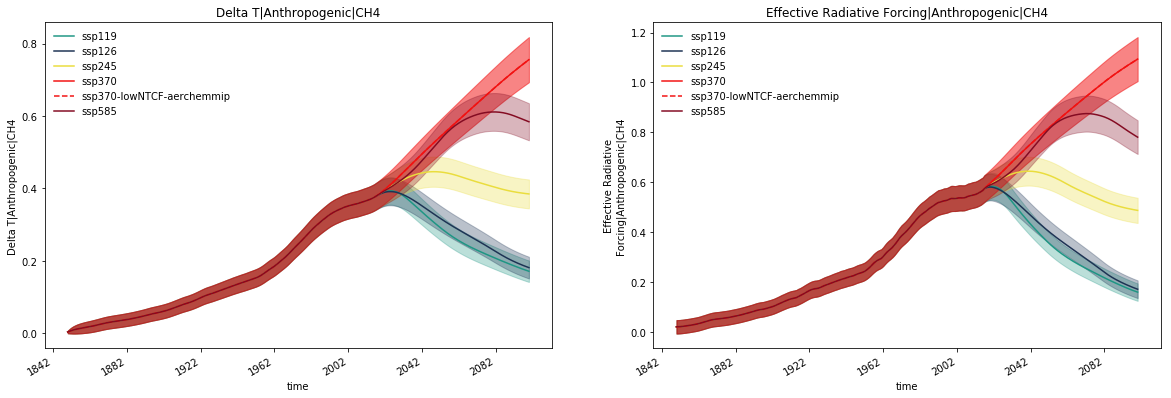

Effective Radiative Forcing|Anthropogenic|Aerosols


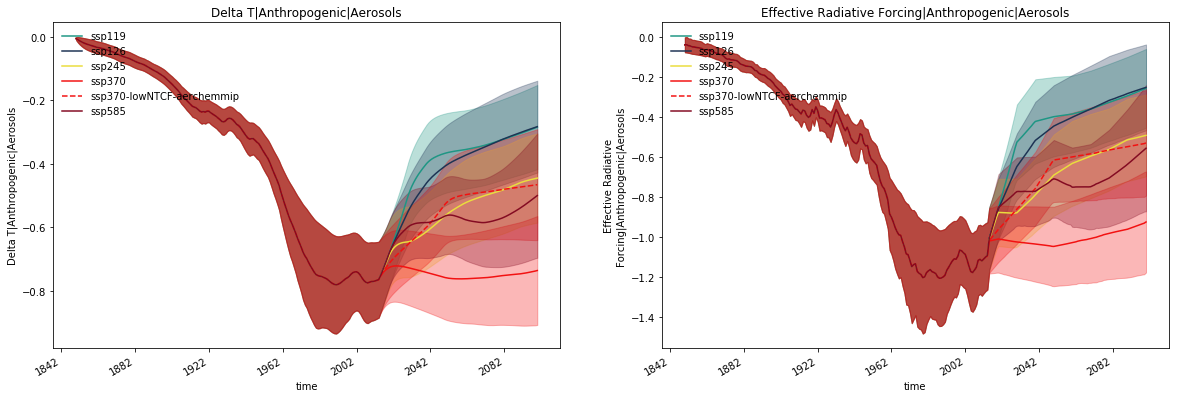

Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone


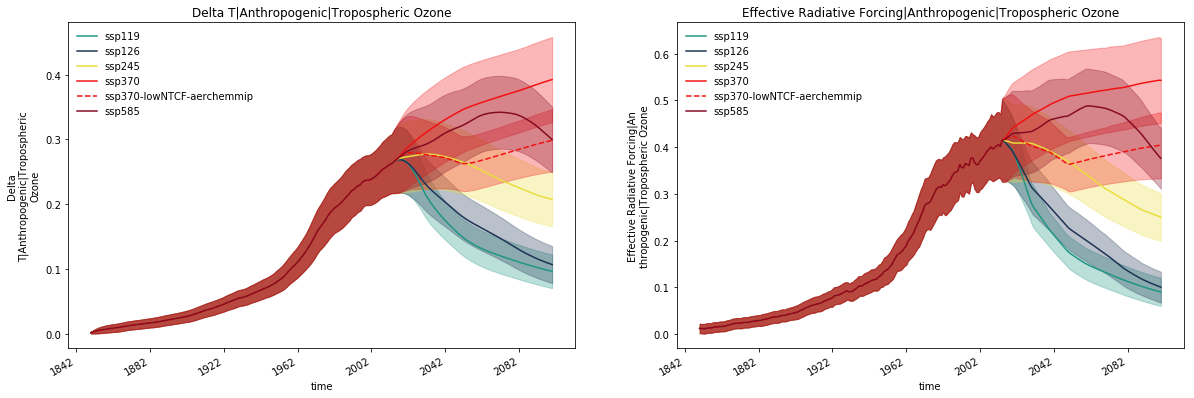

Effective Radiative Forcing|Anthropogenic|F-Gases|HFC


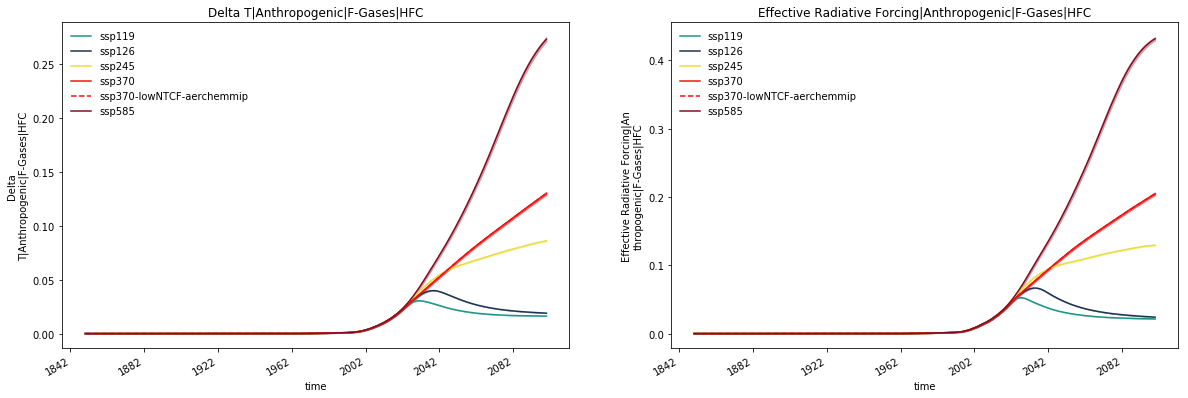

Effective Radiative Forcing|Anthropogenic|Other|BC on Snow


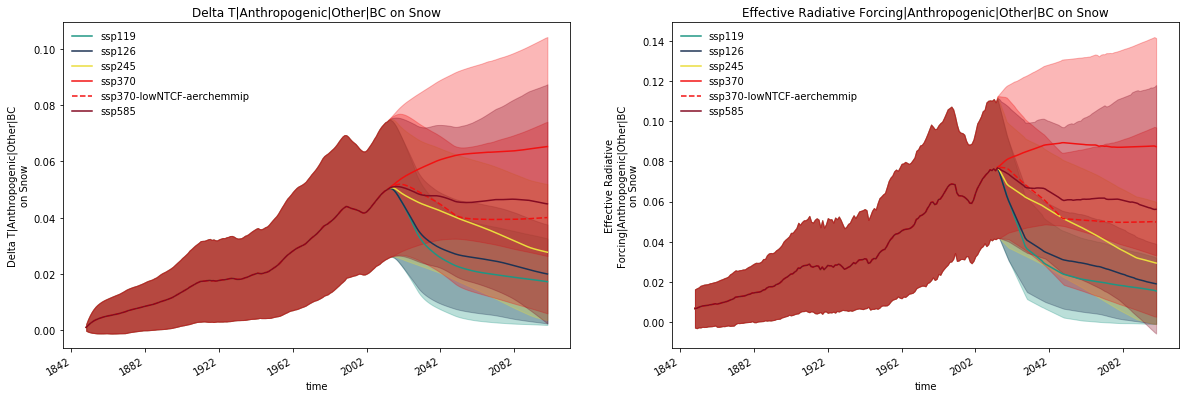

<IPython.core.display.Javascript object>

In [36]:
from misc_func import get_scenario_ls_dic
lsdic = get_scenario_ls_dic()#get_ls_dic(ds_DT[climatemodel].values)
s_y = '2021'
e_y = '2100'
cdic = get_scenario_c_dic()
alpha = 0.3
for var in variables_erf_comp:
    fig, axs = plt.subplots(1, 2, figsize=[20, 6])
    for scn in scenarios_fl:#) - {'historical'}):
        first = True
        _da1 = ds_DT[new_varname(var, name_deltaT)].sel(scenario=scn)        
        _da2 = ds_DT[var].sel(scenario=scn)
        for _da, ax in zip([_da1, _da2], axs):
            _pl_da = _da.mean(climatemodel)
            _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle = lsdic[scn])
            _std = _da.std(climatemodel)
            ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=alpha,
                            color=cdic[scn], label='_nolegen_')
            #for cm in _da[climatemodel].values:
            #    _da.sel(climatemodel=cm).plot(ax=ax, color=cdic[scn], label='_nolabel_')
    print(var)

    axs[0].set_title(new_varname(var, name_deltaT))
    axs[1].set_title(var)
    # axs[1].set_title('%s'%( ('|'.join(var.split('|')[1:]))))

    axs[0].legend(frameon=False, loc=2)
    axs[1].legend(frameon=False, loc=2)

    plt.show()

In [37]:
db_test = db_converted_units

<IPython.core.display.Javascript object>

Effective Radiative Forcing|Anthropogenic|CH4


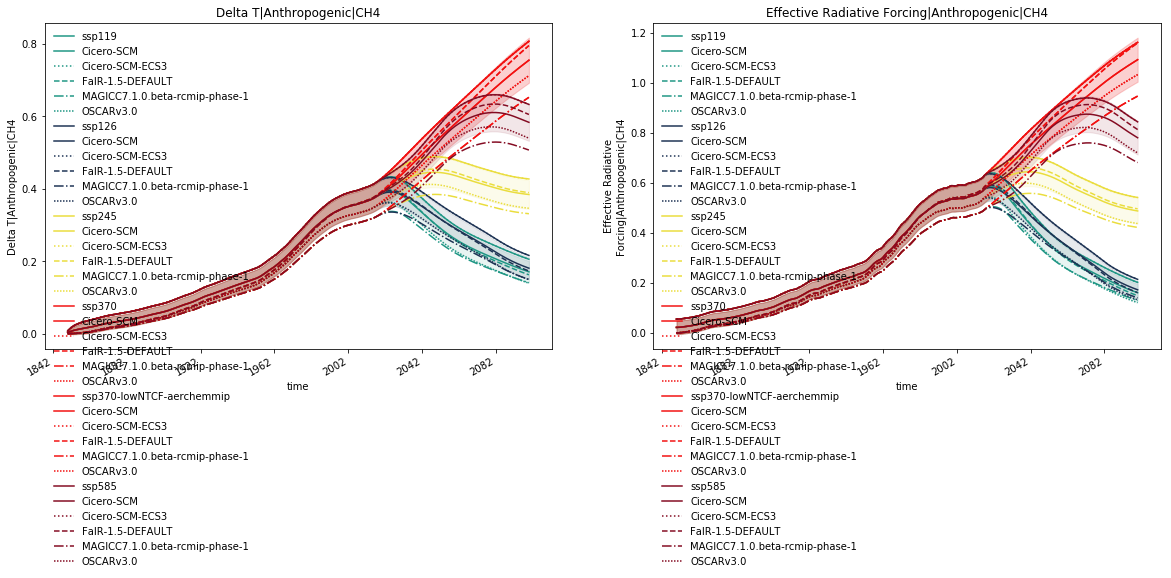

Effective Radiative Forcing|Anthropogenic|Aerosols


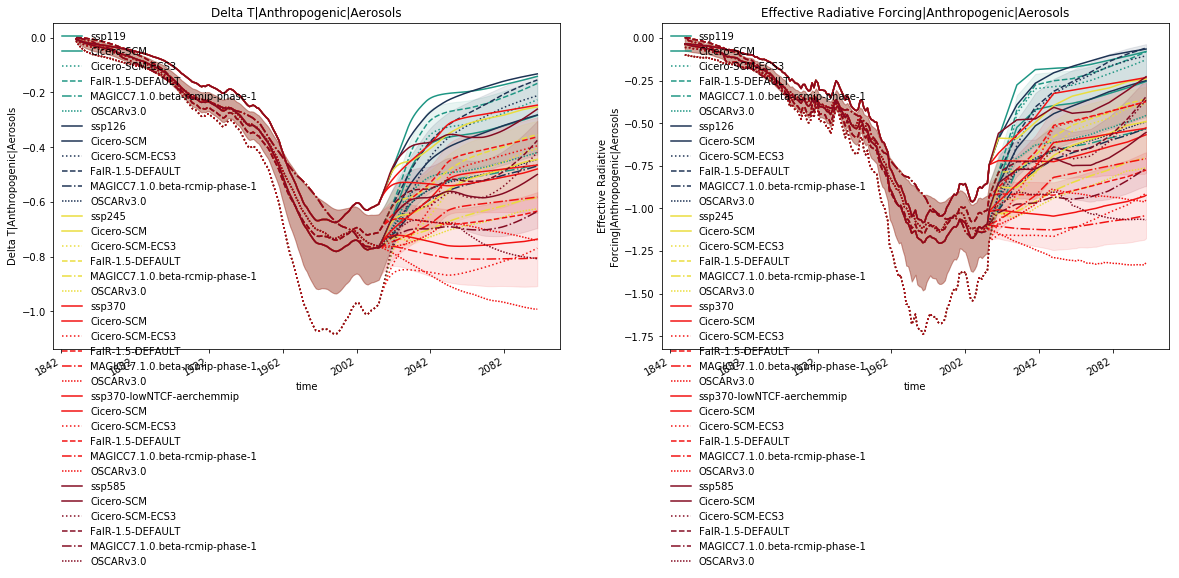

Effective Radiative Forcing|Anthropogenic|Tropospheric Ozone


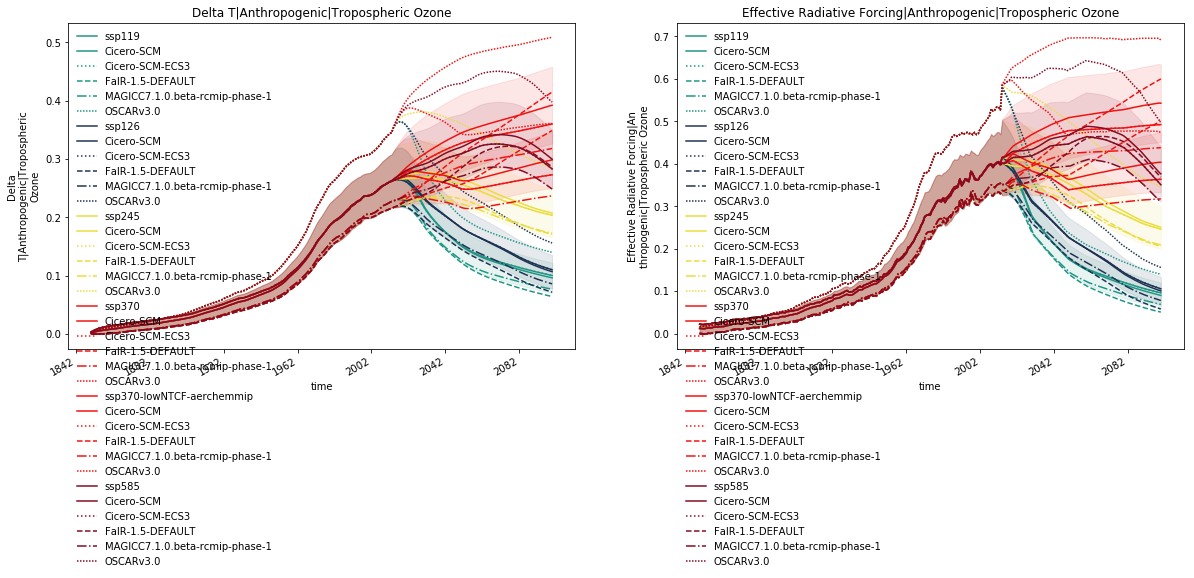

Effective Radiative Forcing|Anthropogenic|F-Gases|HFC


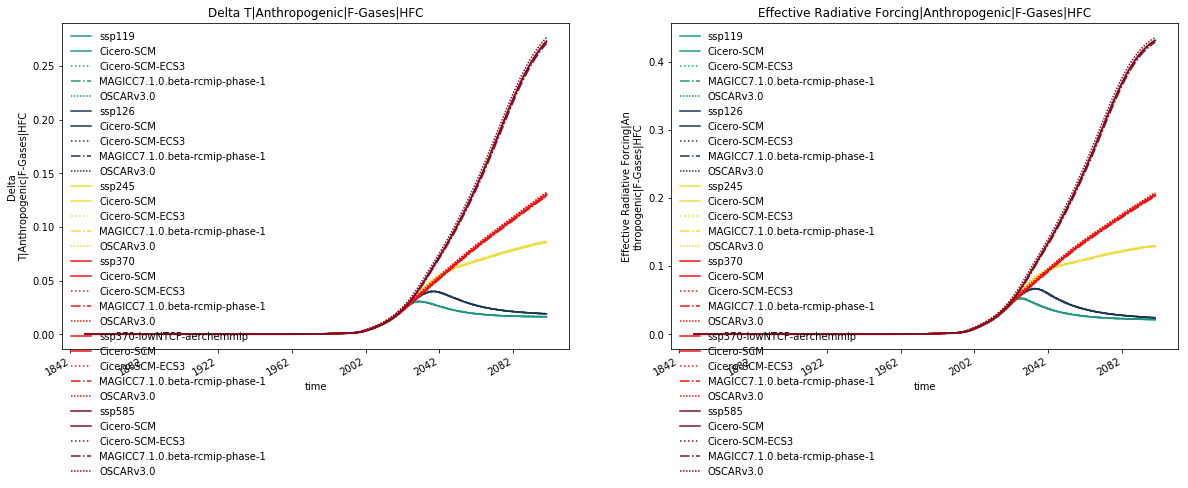

Effective Radiative Forcing|Anthropogenic|Other|BC on Snow


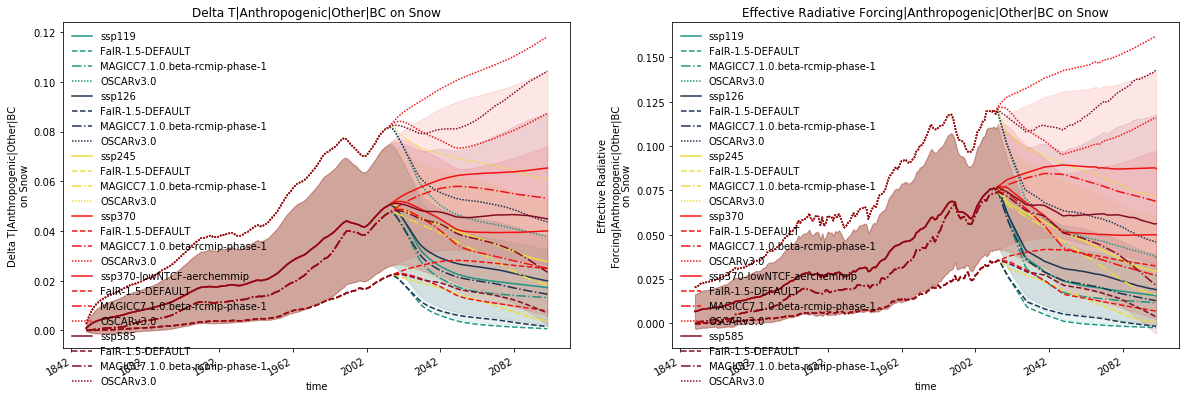

<IPython.core.display.Javascript object>

In [38]:

lsdic = get_ls_dic(ds_DT[climatemodel].values)
s_y = '2021'
e_y = '2100'
cdic = get_scenario_c_dic()
ls_dic = get_ls_dic(climatemodels_fl)
for var in variables_erf_comp:
    fig, axs = plt.subplots(1, 2, figsize=[20, 6])
    for scn in scenarios_fl:#list(set(scenarios) - {'historical'}):
        first = True
        _da1 = ds_DT[new_varname(var, name_deltaT)].sel(scenario=scn)        
        _da2 = ds_DT[var].sel(scenario=scn)
        for _da, ax in zip([_da1, _da2], axs):
            _pl_da = _da.mean(climatemodel)
            _pl_da.plot(ax=ax, c=cdic[scn], label=scn)
            _std = _da.std(climatemodel)
            ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=0.1,
                            color=cdic[scn], label='_nolegen_')
            for cm in _da[climatemodel].values:
                if not np.all(_da.sel(climatemodel=cm).isnull()):
                    _da.sel(climatemodel=cm).plot(ax=ax,linestyle=ls_dic[cm], color=cdic[scn], label=cm)
    print(var)

    axs[0].set_title(new_varname(var, name_deltaT))
    axs[1].set_title(var)
    # axs[1].set_title('%s'%( ('|'.join(var.split('|')[1:]))))

    axs[0].legend(frameon=False, loc=2)
    axs[1].legend(frameon=False, loc=2)

    plt.show()

In [39]:
def find_notnan_dims(da, dim='climatemodel'):
    """
    Find which coordinate values contains values and not. 
    """
    dima = da.coords[dim].values
    diml = []
    for _dim in dima:
        if np.any(da.sel(**{dim: _dim}).notnull()):
            diml.append(_dim)
        # print(da.sel(**{dim : _dim}))
    return diml


# find_notnan_dims(_da1)

<IPython.core.display.Javascript object>

## Plot $\Delta$ T and ERF with reference year +/- 1 standard deviation of the models

Subtracting year 2021, while still plotting from 2015. Thus the results represent the cooling/warming with respect to year 2021

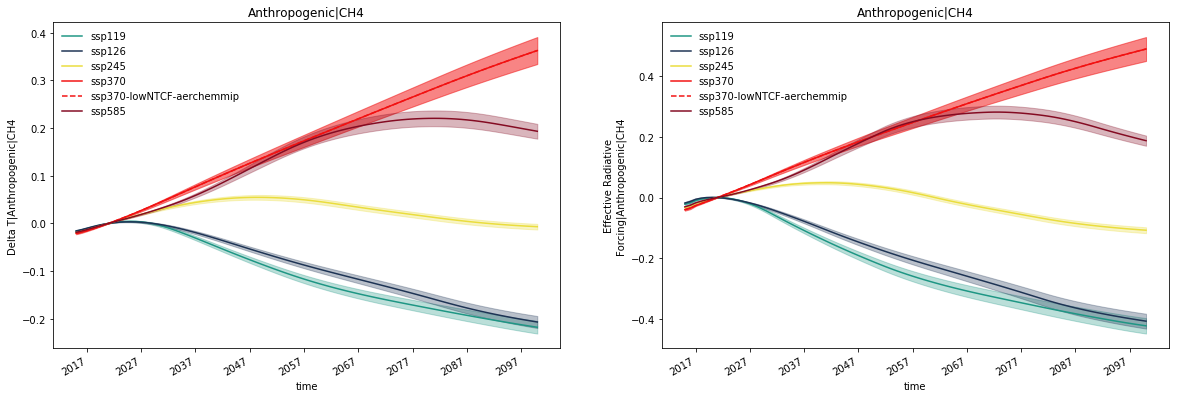

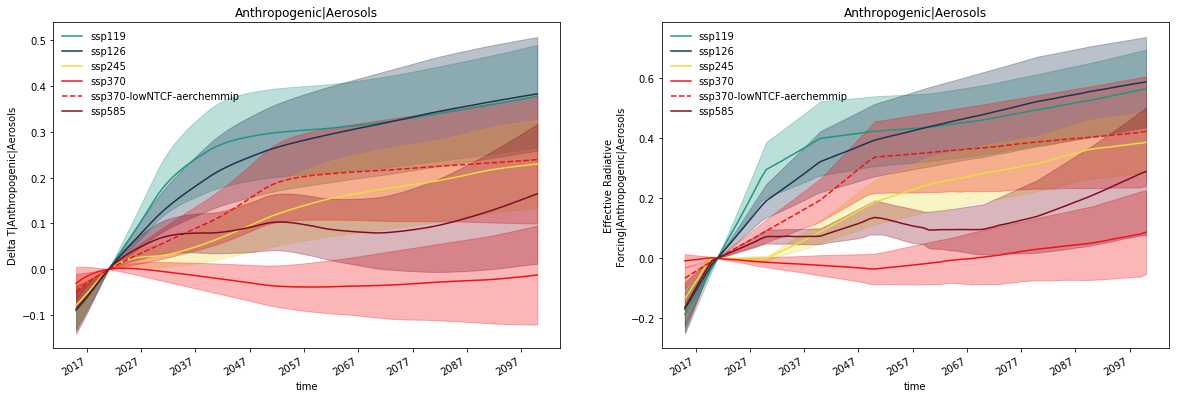

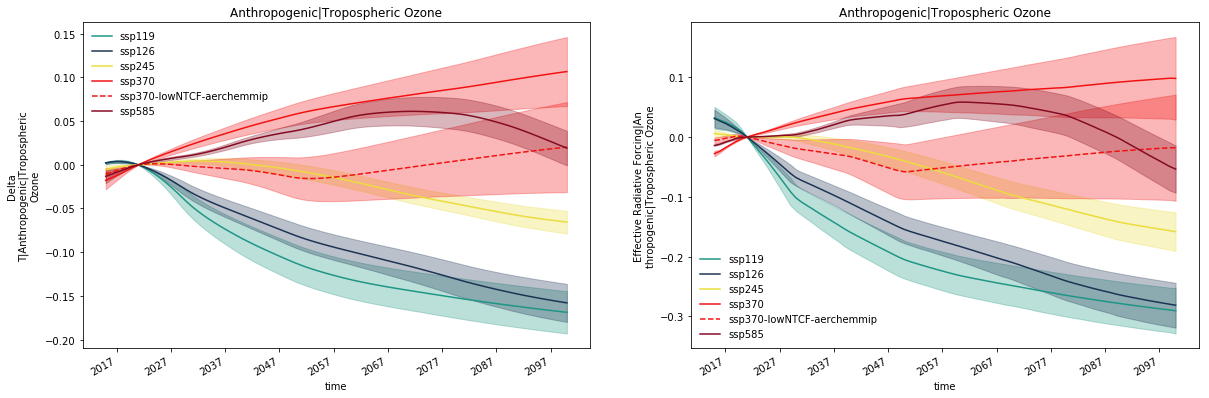

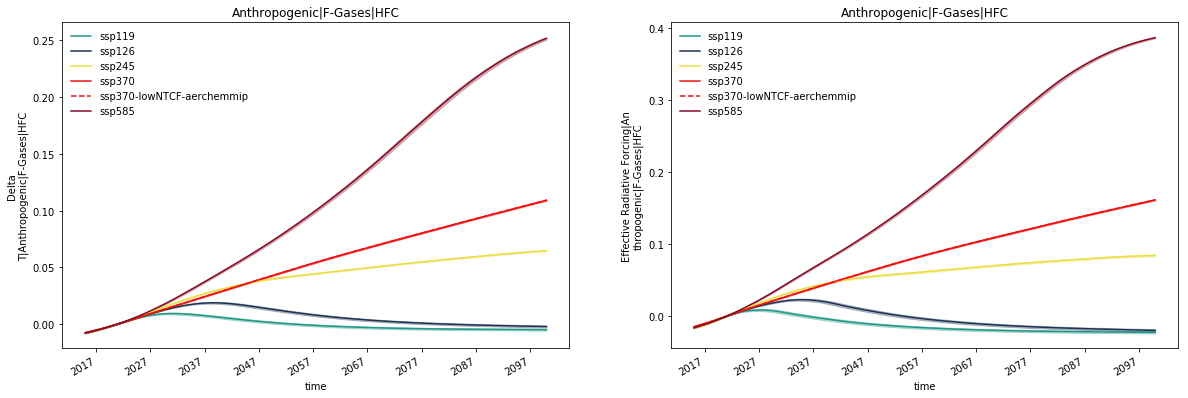

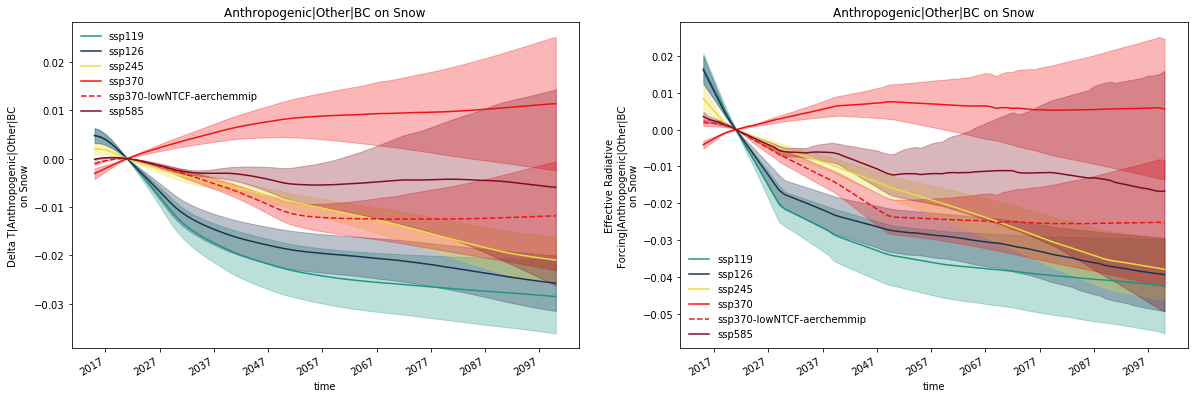

<IPython.core.display.Javascript object>

In [40]:

cdic = get_scenario_c_dic()# get_cmap_dic(ds_DT[scenario].values)
lsdic = get_scenario_ls_dic()# _scget_ls_dic(ds_DT[climatemodel].values)
s_y = '2021'
e_y = '2100'
s_y2 = '2015'
e_y2 = '2100'
cdic = get_scenario_c_dic()

for var in variables_erf_comp:
    fig, axs = plt.subplots(1, 2, figsize=[20, 6])
    for scn in scenarios_fl:#list(set(scenarios) - {'historical'}):
        first = True
        _da1 = ds_DT[new_varname(var, name_deltaT)].sel(scenario=scn, time=slice(s_y2, e_y2)) - ds_DT[
            new_varname(var, name_deltaT)].sel(
            scenario=scn, time=slice(s_y, s_y)).squeeze()
        _da2 = ds_DT[var].sel(scenario=scn, time=slice(s_y2, e_y2)) - ds_DT[var].sel(scenario=scn,
                                                                                     time=slice(s_y, s_y)).squeeze()
        for _da, ax in zip([_da1, _da2], axs):
            _pl_da = _da.mean(climatemodel)
            _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle = lsdic[scn])
            _std = _da.std(climatemodel)
            ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=0.3,
                            color=cdic[scn], label='_nolegen_')
    axs[0].set_title('%s' % (('|'.join(var.split('|')[1:]))))
    axs[1].set_title('%s' % (('|'.join(var.split('|')[1:]))))

    axs[0].legend(frameon=False)  # , loc=2)
    axs[1].legend(frameon=False)  # , loc=2)

    plt.show()

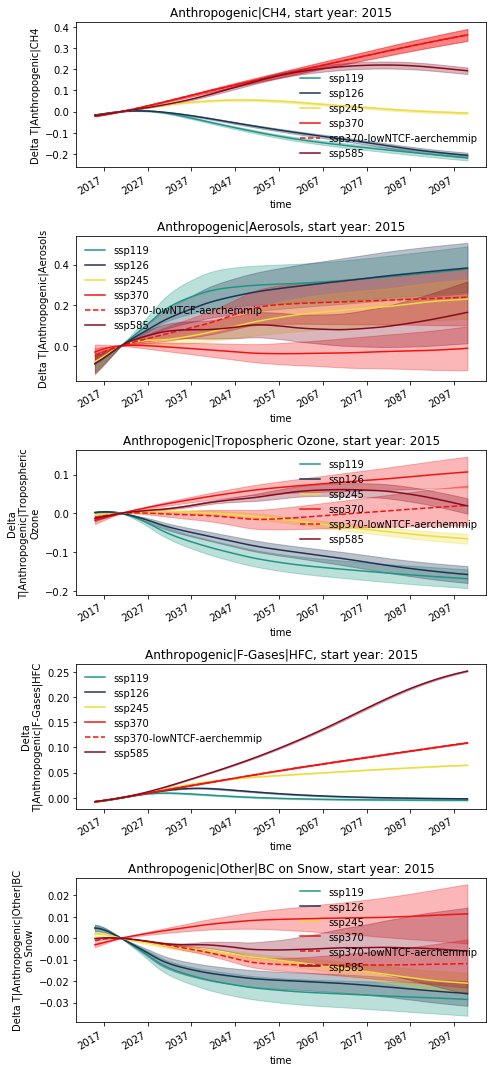

<IPython.core.display.Javascript object>

In [41]:
from misc_func import get_scenario_ls_dic

cdic = get_scenario_c_dic()# get_cmap_dic(ds_DT[scenario].values)
lsdic = get_scenario_ls_dic()# _scget_ls_dic(ds_DT[climatemodel].values)
s_y = '2015'
e_y = '2100'
s_y2 = '2021'
e_y2 = '2100'


fig, axs = plt.subplots(len(variables_erf_comp), 1, figsize=[7, 15])

for var, ax in zip(variables_erf_comp, axs):
    # print(var)
    for scn in scenarios_fl:#list(set(scenarios) - {'historical'}):
        # first=True
        _da = ds_DT[new_varname(var, name_deltaT)].sel(scenario=scn, time=slice(s_y, e_y)) - ds_DT[
            new_varname(var, name_deltaT)].sel(
            scenario=scn, time=slice(s_y2, s_y2)).squeeze()
        # _da2 = ds_DT[nvar(var, nname)].sel(scenario=scn, time=slice(s_y2,e_y2))- ds_DT[nvar(var, nname)].sel(scenario=scn, time=slice(s_y2,s_y2)).squeeze()
        # _da2 = ds_DT[var].sel(scenario=scn, time=slice(s_y,e_y))- ds_DT[var].sel(scenario=scn, time=slice(s_y,s_y)).squeeze()
        # for _da, ax in zip([_da1, _da2], axs):
        _pl_da = _da.mean(climatemodel)
        _pl_da.plot(ax=ax, c=cdic[scn], linestyle = lsdic[scn], label=scn)
        _std = _da.std(climatemodel)
        ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=0.3,
                        color=cdic[scn], label='_nolegen_')
        ax.set_title('%s, start year: %s' % (('|'.join(var.split('|')[1:])), s_y))
        # axs[1].set_title('%s, start year: %s'%( ('|'.join(var.split('|')[1:])), s_y2))
        # axs[1].set_title('%s'%( ('|'.join(var.split('|')[1:]))))

        ax.legend(frameon=False)  # , loc=2)
    # axs[1].legend(frameon=False)#, loc=2)

plt.tight_layout()
plt.show()

## Sum of SLCFs  


#### FROM 1850

In [42]:

# ds_DT = dic_ds[0.885]
s_y = '1850'
# cdic = get_scenario_c_dic()

cdic = get_scenario_c_dic()# get_cmap_dic(ds_DT[scenario].values)
lsdic = get_scenario_ls_dic()# _scget_ls_dic(ds_DT[climatemodel].values)


def sum_name(var): return '|'.join(var.split('|')[0:2]) + '|' + 'All'


var = variables_erf_comp[0]
f_totn = sum_name(var)
dt_totn = sum_name(new_varname(var, name_deltaT))

# make xarray with variable as new dimension:
_lst_f = []
_lst_dt = []
for var in variables_erf_comp:
    _lst_f.append(ds_DT[var])
    _lst_dt.append(ds_DT[new_varname(var, name_deltaT)])
erf_all = sum_name('Effective Radiative Forcing|Anthropogenic|all')
dt_all = sum_name(new_varname('Effective Radiative Forcing|Anthropogenic|all', name_deltaT))
ds_DT[erf_all] = xr.concat(_lst_f, pd.Index(variables_erf_comp, name='variable'))
ds_DT[dt_all] = xr.concat(_lst_dt, pd.Index(variables_erf_comp, name='variable'))

<IPython.core.display.Javascript object>

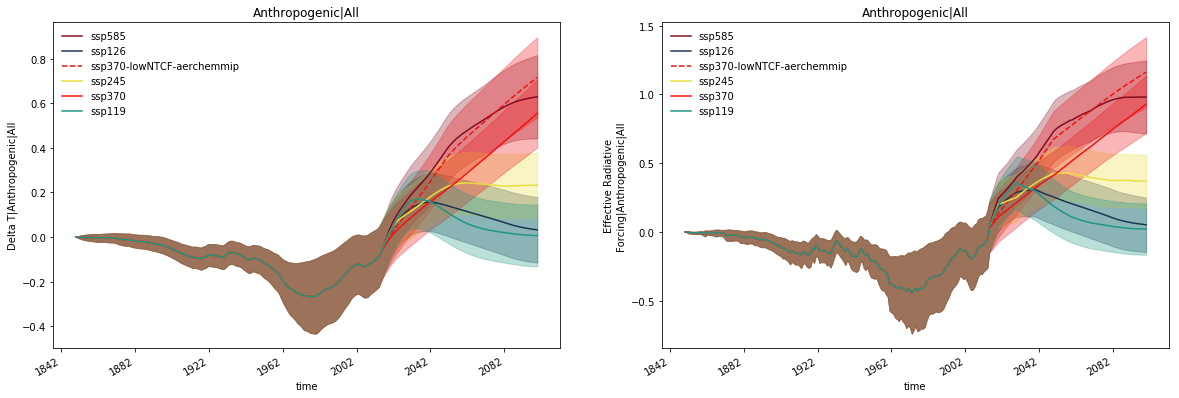

<IPython.core.display.Javascript object>

In [43]:
fig, axs = plt.subplots(1, 2, figsize=[20, 6])
cdic = get_scenario_c_dic()# get_cmap_dic(ds_DT[scenario].values)
lsdic = get_scenario_ls_dic()# _scget_ls_dic(ds_DT[climatemodel].values)

for var, ax in zip([dt_totn, f_totn], axs):
    for scn in list(set(scenarios) - {'historical'}):
        first = True
        _da = ds_DT[var].sel(scenario=scn)
        _da = ds_DT[var].sel(scenario=scn, time=slice(s_y, e_y)) - ds_DT[var].sel(scenario=scn,
                                                                                  time=slice(s_y, s_y)).squeeze()
        # _da2 = ds_DT[nvar(var, nname)].sel(scenario=scn, time=slice(s_y2,e_y2))- ds_DT[nvar(var, nname)].sel(scenario=scn, time=slice(s_y2,s_y2)).squeeze()

        _pl_da = _da.sum(variable)
        _pl_da = _pl_da.mean(climatemodel)
        _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle = lsdic[scn])
        _std = _da.sum(variable).std(climatemodel)
        #print(_std)
        ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=0.3,
                        color=cdic[scn], label='_nolegend_')
axs[0].set_title('%s' % (('|'.join(var.split('|')[1:]))))
axs[1].set_title('%s' % (('|'.join(var.split('|')[1:]))))

axs[0].legend(frameon=False)  # , loc=2)
axs[1].legend(frameon=False)  # , loc=2)

plt.show()

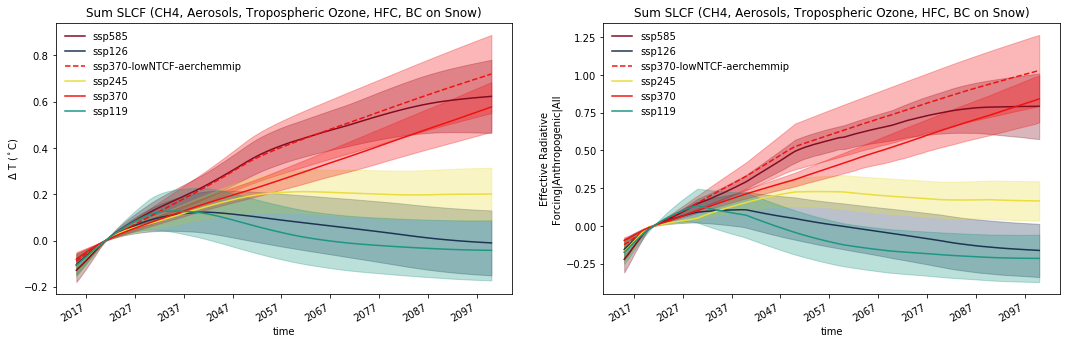

<IPython.core.display.Javascript object>

In [44]:
cdic = get_scenario_c_dic()# get_cmap_dic(ds_DT[scenario].values)
lsdic = get_scenario_ls_dic()# _scget_ls_dic(ds_DT[climatemodel].values)

s_y = '2021'
s_y2 = '2015'
e_y = '2100'
e_y2 = '2100'
fig, axs = plt.subplots(1, 2, figsize=[18, 5])

for var, ax in zip([dt_totn, f_totn], axs):
    for scn in list(set(scenarios_fl) - {'historical'}):
        first = True
        _da = ds_DT[var].sel(scenario=scn)
        _da = ds_DT[var].sel(scenario=scn, time=slice(s_y2, e_y2)) - ds_DT[var].sel(scenario=scn,
                                                                                    time=slice(s_y, s_y)).squeeze()
        # _da2 = ds_DT[nvar(var, nname)].sel(scenario=scn, time=slice(s_y2,e_y2))- ds_DT[nvar(var, nname)].sel(scenario=scn, time=slice(s_y2,s_y2)).squeeze()
        # _pl_da = _da.sum(variable)
        _pl_da = _da.mean(climatemodel)
        _pl_da = _pl_da.sum(variable)
        _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle = lsdic[scn])
        _std = _da.sum(variable).std(climatemodel)
        # print(_std)
        ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=0.3,
                        color=cdic[scn], label='_nolegend_')
_str = ''
for var in ds_DT[variable].values: _str += '%s, ' % var.split('|')[-1]
axs[0].set_title('Sum SLCF (%s)' % _str[:-2])
axs[1].set_title('Sum SLCF (%s)' % _str[:-2])
# axs[1].set_title('%s'%( ('|'.join(var.split('|')[1:]))))
axs[0].set_ylabel('$\Delta$ T ($^\circ$C)')
axs[0].legend(frameon=False)  # , loc=2)
axs[1].legend(frameon=False)  # , loc=2)

plt.savefig('total_ref2021_from2015_.png')
plt.show()

# Final plot:

Delta T|Anthropogenic|CH4


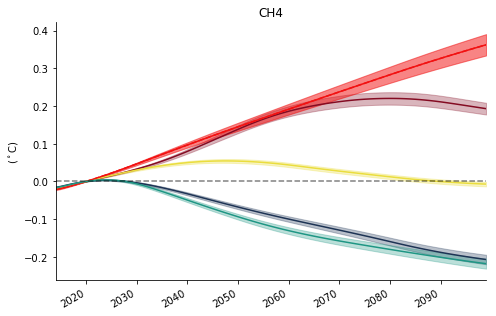

Delta T|Anthropogenic|Aerosols


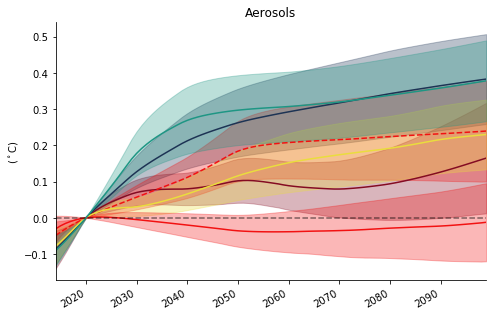

Delta T|Anthropogenic|Tropospheric Ozone


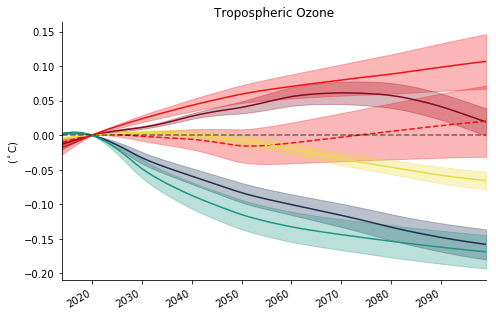

Delta T|Anthropogenic|F-Gases|HFC


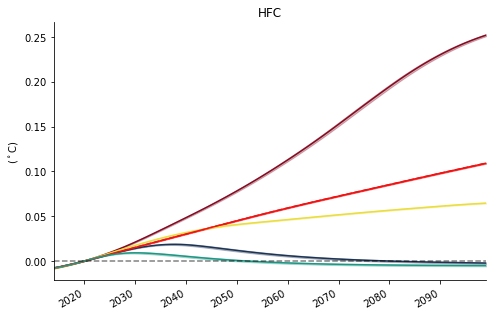

Delta T|Anthropogenic|Other|BC on Snow


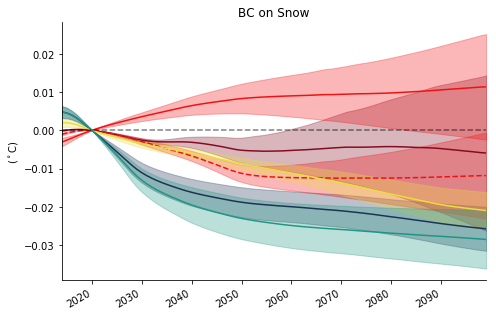

Delta T|Anthropogenic|All


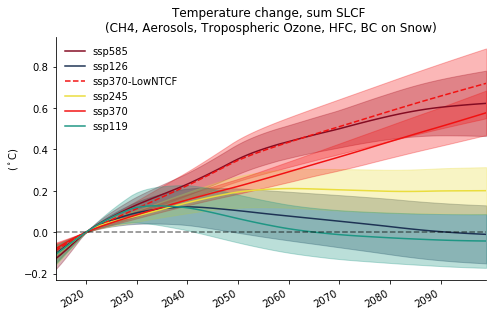

<IPython.core.display.Javascript object>

In [45]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from misc import make_folders
from misc_func import trans_scen2plotlabel

figsize = [7, 4.5]
s_y = '2021'
s_y2 = '2015'
e_y = '2100'
e_y2 = '2100'
# fig, axs = plt.subplots(1,2, figsize=[18,5])
cdic = get_cmap_dic(ds_DT[scenario].values)
lsdic = get_scenario_ls_dic()#get_ls_dic(ds_DT[climatemodel].values)

s_y = '2021'
e_y = '2100'
s_y2 = '2015'
e_y2 = '2100'
cdic = get_scenario_c_dic()


# fig, axs = plt.subplots(3,2, figsize=[20,20])
def fix_ax(ax):
    ls = pd.date_range('2010-1-1', periods=100, freq='Y')[0::10]
    ax.set_xticks(list(ls))
    ax.set_xlim(s_y2, e_y2)  # '2015','2100')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return


# axs, ax_tot = get_fig_ax_tot()#fig3 = plt.figure(constrained_layout=True)
# f3_ax1.set_title('gs[0, :]')
for var in variables_dt_comp:
    print(var)

    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for scn in list(set(scenarios_fl) - {'historical'}):
        first = True
        _da = ds_DT[var].sel(scenario=scn, time=slice(s_y2, e_y2)) - ds_DT[new_varname(var, name_deltaT)].sel(
            scenario=scn,
            time=slice(s_y,
                       s_y)).squeeze()
        # _da2 = ds_DT[var].sel(scenario=scn, time=slice(s_y2,e_y2))- ds_DT[var].sel(scenario=scn, time=slice(s_y,s_y)).squeeze()
        _pl_da = _da.mean(climatemodel)
        _pl_da.plot(ax=ax, c=cdic[scn], label=scn, linestyle = lsdic[scn])
        _std = _da.std(climatemodel)
        ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=0.3,
                        color=cdic[scn], label='_nolegen_')
    ax.set_title('%s' % (('|'.join(var.split('|')[1:]))))
    # axs[1].set_title('%s'%( ('|'.join(var.split('|')[1:]))))

    # ax.legend(frameon=False)#, loc=2)
    # axs[1].legend(frameon=False)#, loc=2)

    # plt.show()
    ax.set_title('%s' % var.split('|')[-1])
    #ax.set_ylabel('$\Delta$ T ($^\circ$C)')
    #ax.set_ylabel('Change in temperature (C$^\circ$)')
    ax.set_ylabel('($^\circ$C)')
    ax.set_xlabel('')
    fign = 'plots/%s_refy%s_fy%s.png' % (var.replace(' ', '_').replace('|', '-'), s_y, s_y2)
    make_folders(fign)
    fix_ax(ax)
    _ds = ds_DT.sel(time=slice(s_y2, e_y2))
    #_ds = ds_DT.sel(time=slice(s_y2, e_y2))
    ax.plot(_ds['time'], np.zeros(len(_ds['time'])), c='k', alpha=0.5, linestyle='dashed')

    plt.tight_layout()
    plt.savefig(fign, dpi=200)
    plt.show()

# Total:
# ax= ax_tot#fig3.add_subplot(gs[:, 1])
fig, ax = plt.subplots(1, 1, figsize=figsize)  # [9,5])

cdic = get_scenario_c_dic()
# ax = axs[-1,-1]
_ds = ds_DT.sel(time=slice(s_y2, e_y2))

for var in [dt_totn]:  # , f_totn]:
    print(var)
    for scn in list(set(scenarios_fl) - {'historical'}):
        # Plot dataset difference to first year, i.e.
        ds_DT_sy = ds_DT[var].sel(scenario=scn,
                       time=slice(s_y, s_y)).squeeze()
        _da = ds_DT[var].sel(scenario=scn, time=slice(s_y2, e_y2)) - ds_DT_sy
        # Take mean over climate models:
        _pl_da = _da.mean(climatemodel)
        # Sum up the variables:
        _pl_da = _pl_da.sum(variable)
        # plot :
        _pl_da.plot(ax=ax, c=cdic[scn], label=trans_scen2plotlabel(scn), xticks=[], linestyle = lsdic[scn])
        # calculate standard deviation over the models:
        _std = _da.sum(variable).std(climatemodel)
        # Fill between +/- 1 std
        ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=0.3,
                        color=cdic[scn], label='_nolegend_')

# adjust plot visuals:
_str = ''
for var in ds_DT[variable].values: _str += '%s, ' % var.split('|')[-1]
#ax.set_title('Sum SLCF (%s)' % _str[:-2])
ax.set_title('Temperature change, sum SLCF \n(%s)' % _str[:-2])

#ax.set_ylabel('$\Delta$ T ($^\circ$C)')
#ax.set_ylabel('Change in temperature (C$^\circ$)')
ax.set_ylabel('($^\circ$C)')
ax.set_xlabel('')

ax.legend(frameon=False, loc=2)
fix_ax(ax)
_ds = ds_DT.sel(time=slice(s_y2, e_y2))
ax.plot(_ds['time'], np.zeros(len(_ds['time'])), c='k', alpha=0.5, linestyle='dashed')

plt.tight_layout()
plt.savefig('plots/total_ref2021_from2015_all_.png', dpi=200)
plt.show()

Delta T|Anthropogenic|CH4
Delta T|Anthropogenic|Aerosols
Delta T|Anthropogenic|Tropospheric Ozone
Delta T|Anthropogenic|F-Gases|HFC
Delta T|Anthropogenic|Other|BC on Snow
Delta T|Anthropogenic|All


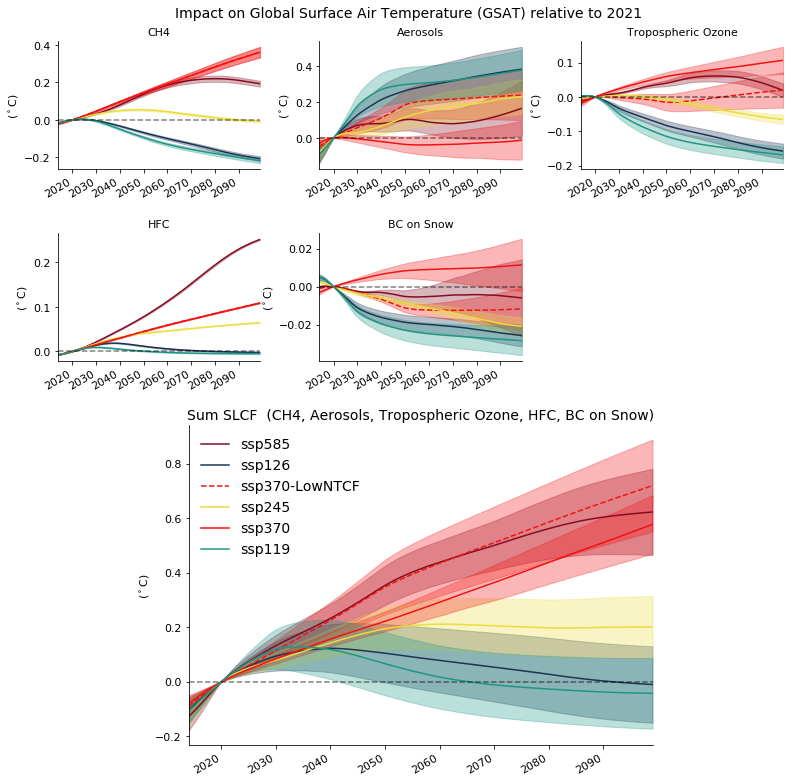

<IPython.core.display.Javascript object>

In [46]:
from misc_func import trans_scen2plotlabel
def get_fig_ax_tot(figsize=[13,12]):
    fig2 = plt.figure(constrained_layout=False, figsize=figsize)
    spec2 = gridspec.GridSpec(ncols=12, nrows=4, figure=fig2)
    com_axs = []
    for i in np.arange(2):
        for j in np.arange(3):
            if i==1 and j==2: continue
            com_axs.append(fig2.add_subplot(spec2[i, j*4:(j+1)*4]))
    all_ax = fig2.add_subplot(spec2[2:, 2:10])
    return fig2, com_axs, all_ax


#get_fig_ax_tot

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from misc import make_folders

figsize = [6, 4]
s_y = '2021'
s_y2 = '2015'
e_y = '2100'
e_y2 = '2100'
# fig, axs = plt.subplots(1,2, figsize=[18,5])
cdic = get_cmap_dic(ds_DT[scenario].values)
lsdic = get_scenario_ls_dic()#get_ls_dic(ds_DT[climatemodel].values)

s_y = '2021'
e_y = '2100'
s_y2 = '2015'
e_y2 = '2100'
cdic = get_scenario_c_dic()
SMALL_SIZE = 11
MEDIUM_SIZE = 11
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# fig, axs = plt.subplots(3,2, figsize=[20,20])
def fix_ax(ax):
    ls = pd.date_range('2010-1-1', periods=100, freq='Y')[0::10]
    ax.set_xticks(list(ls))
    ax.set_xlim(s_y2, e_y2)  # '2015','2100')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return


fig2, axs, ax_tot = get_fig_ax_tot()#fig3 = plt.figure(constrained_layout=True)
# f3_ax1.set_title('gs[0, :]')
_ds = ds_DT.sel(time=slice(s_y2, e_y2))
for var, ax in zip(variables_dt_comp, axs):

    print(var)

    #fig, ax = plt.subplots(1, 1, figsize=figsize)
    for scn in list(set(scenarios_fl) - {'historical'}):
        first = True
        _da = ds_DT[var].sel(scenario=scn, time=slice(s_y2, e_y2)) - ds_DT[new_varname(var, name_deltaT)].sel(
            scenario=scn,
            time=slice(s_y,
                       s_y)).squeeze()
        # _da2 = ds_DT[var].sel(scenario=scn, time=slice(s_y2,e_y2))- ds_DT[var].sel(scenario=scn, time=slice(s_y,s_y)).squeeze()
        _pl_da = _da.mean(climatemodel)
        _pl_da.plot(ax=ax, c=cdic[scn], label=trans_scen2plotlabel(scn), linestyle = lsdic[scn])
        _std = _da.std(climatemodel)
        ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=0.3,
                        color=cdic[scn], label='_nolegen_')
    ax.set_title('%s' % (('|'.join(var.split('|')[1:]))))
    # axs[1].set_title('%s'%( ('|'.join(var.split('|')[1:]))))

    # ax.legend(frameon=False)#, loc=2)
    # axs[1].legend(frameon=False)#, loc=2)

    # plt.show()
    ax.set_title('%s' % var.split('|')[-1])
    #ax.set_ylabel('$\Delta$ T ($^\circ$C)')
    ax.set_ylabel('')#Change in temperature (C$^\circ$)')
    ax.set_xlabel('')
    fign = 'plots/%s_refy%s_fy%s.png' % (var.replace(' ', '_').replace('|', '-'), s_y, s_y2)
    make_folders(fign)
    fix_ax(ax)
    #plt.tight_layout()
    #plt.savefig(fign, dpi=200)
    #plt.show()
    ax.plot(_ds['time'], np.zeros(len(_ds['time'])), c='k', alpha=0.5, linestyle='dashed')
    
    
axs[0].set_ylabel('($^\circ$C)')
for ax in axs:
    #ax.set_ylabel('Change in temperature (C$^\circ$)')
    ax.set_ylabel('($^\circ$C)')
# Total:
# ax= ax_tot#fig3.add_subplot(gs[:, 1])
#fig, ax = plt.subplots(1, 1, figsize=figsize)  # [9,5])

SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ax = ax_tot

cdic = get_scenario_c_dic()
# ax = axs[-1,-1]
for var in [dt_totn]:  # , f_totn]:
    print(var)
    for scn in list(set(scenarios_fl) - {'historical'}):
        # Plot dataset difference to first year, i.e.
        ds_DT_sy = ds_DT[var].sel(scenario=scn,
                       time=slice(s_y, s_y)).squeeze()
        _da = ds_DT[var].sel(scenario=scn, time=slice(s_y2, e_y2)) - ds_DT_sy
        # Take mean over climate models:
        _pl_da = _da.mean(climatemodel)
        # Sum up the variables:
        _pl_da = _pl_da.sum(variable)
        # plot :
        _pl_da.plot(ax=ax, c=cdic[scn], label=trans_scen2plotlabel(scn), xticks=[], linestyle = lsdic[scn])
        # calculate standard deviation over the models:
        _std = _da.sum(variable).std(climatemodel)
        # Fill between +/- 1 std
        ax.fill_between(_pl_da['time'].values, _pl_da - _std, _pl_da + _std, alpha=0.3,
                        color=cdic[scn], label='_nolegend_')
_ds = ds_DT.sel(time=slice(s_y2, e_y2))
ax.plot(_ds['time'], np.zeros(len(_ds['time'])), c='k', alpha=0.5, linestyle='dashed')
plt.suptitle('Impact on Global Surface Air Temperature (GSAT) relative to 2021', fontsize=14)
# adjust plot visuals:
_str = ''
for var in ds_DT[variable].values: _str += '%s, ' % var.split('|')[-1]
#ax.set_title('Temperature change, sum SLCF  (%s)' % _str[:-2])
ax.set_title('Sum SLCF  (%s)' % _str[:-2])
#ax.set_ylabel('$\Delta$ T ($^\circ$C)')
ax.set_ylabel('($^\circ$C)')
ax.set_xlabel('')

ax.legend(frameon=False, loc=2)
fix_ax(ax)
plt.subplots_adjust(top=0.94, left=0.125, wspace=9.1, hspace=.5)
#plt.tight_layout()
plt.savefig('plots/total_ref2021_from2015_all_2.png', dpi=300)
plt.show()

- Mere årstall
- 2020 og hvert 20ende år
- flere ticks hvert 10ende år.
- skal format hver av dem
- 

## Make plot like Rogelj 2014, pnas

In [47]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


s_y = '2021'
s_y2 = '2000'
e_y = '2100'
e_y2 = '2100'

scenarios_ss = ['ssp126','ssp245' 'ssp585']
ref_var_erf = 'Effective Radiative Forcing|Anthropogenic'
ref_var_dt = new_varname(ref_var_erf, name_deltaT)
# make subset and ref to year s_y:
_ds = ds_DT.sel(scenario=scenarios_ss, time=slice(s_y2, e_y2)) - ds_DT.sel(scenario=scenarios_ss,
                                                                           time=slice(s_y, s_y)).squeeze()
cdic1 = get_cmap_dic(variables_erf_comp, palette='bright')
cdic2 = get_cmap_dic(variables_dt_comp, palette='bright')
cdic = dict(**cdic1, **cdic2)
first=True
for ref_var, varl, ax in zip([ref_var_dt],
                             [variables_dt_comp, variables_erf_comp], axs):
    fig, ax = plt.subplots(1, figsize=[7, 4.5])
    ax.plot(_ds['time'], np.zeros(len(_ds['time'])), c='k', alpha=0.5, linestyle='dashed')
    # print(ref_var)
    for scn in scenarios_ss[:]:
        # print(scn)
        # subtract year 
        _base = _ds[ref_var]  # _ds.sel(scenario=scn)
        _base = _base.sel(scenario=scn,
                          time=slice(s_y2, e_y2))  # -_base.sel(scenario=scn, time=slice(s_y, s_y)).squeeze()
        # .mean(climatemodel)
        base_keep = _base.mean(climatemodel)
        basep = _base.mean(climatemodel)
        basem = _base.mean(climatemodel)
        # print(base)
        if first:
            base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='Scenario total ')
            first=False
        else:
            base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='_nolegend_')
            
        scen_ds = _ds[varl] - base_keep
        test_df = scen_ds.sel(scenario=scn).mean(climatemodel).to_dataframe()
        for var in varl:
            if scn == scenarios_ss[0]:
                #label = '$\Delta$T ' + var.split('|')[-1]
                label = ' ' + var.split('|')[-1]
            else:
                label = '_nolegend_'

            _pl_da = (_ds[var].sel(scenario=scn, time=slice(s_y2, e_y2)).mean(climatemodel))  # -base_keep)
            if _pl_da.mean() <= 0:
                # print(var)

                ax.fill_between(base_keep['time'].values, basep, -_pl_da + basep, alpha=0.5,
                                color=cdic[var], label=label)
                basep = basep - _pl_da
            else:
                print('here')
                ax.fill_between(base_keep['time'].values, basem, basem - _pl_da, alpha=0.5,
                                color=cdic[var], label=label)
                basem = basem - _pl_da
        if 'Delta T' in ref_var:
            x_val = '2078'
            y_val = base_keep.sel(time=x_val)
            if scn == 'ssp585':
                kwargs = {'xy': (x_val, y_val + .90), 'rotation': 28.6}
            else:
                kwargs = {'xy': (x_val, y_val + .4)}
            #ax.annotate('$\Delta$T, %s' % scn, **kwargs)
            ax.annotate(' %s' % scn, **kwargs)

    ax.legend(frameon=False, loc=2)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_xlim([s_y2, e_y2])
    #ax.set_ylabel('$\Delta$T (C$^\circ$)')
    ax.set_ylabel('($^\circ$C)')
    ax.set_xlabel('')
    plt.title('Temperature change contributions by SLCF\'s in two scenarios', fontsize=14)
    plt.tight_layout()
    plt.savefig('plots/ssp858_126_relative_contrib.png', dpi=300)
    plt.show()

KeyError: "not all values found in index 'scenario'"

<IPython.core.display.Javascript object>

## What question does the graph answer?
- What are the relative contributions of SLCFs?
    - The figure above shows the contributions of 5 SLCFs and the total anthropogenic forcing in two scenarios (black line) relative to year 2021. The area signifies the warming (below the total) or cooling (above the stipled line) introduced by changes in the SLCFer in the specific scenario. Note that in the in the businiss as usual scenario, all the SLCFers except BC on snow add to the warming, while in the 126 scenario, the emission control acts to reduce methane, ozone and BC, and these are thus contributing to cooling. Both scenarios include emission controls which act to reduce aerosols relative 2021 and thus the aerosols give warming. However, the warming from aerosols is much stronger in ssp126 because of stricter emission control in this scenario. 

- 


In [ ]:


s_y = '2021'
s_y2 = '2000'
e_y = '2100'
e_y2 = '2100'
optimal_emission_reduction_scn = 'ssp119'
scenarios_ss = ['ssp126', 'ssp585']
ref_var_erf = 'Effective Radiative Forcing|Anthropogenic'
ref_var_dt = new_varname(ref_var_erf, name_deltaT)
# make subset and ref to year s_y:
_ds = ds_DT.sel(scenario=(scenarios_ss + [optimal_emission_reduction_scn]), time=slice(s_y2, e_y2)) - ds_DT.sel(
    scenario=(scenarios_ss + [optimal_emission_reduction_scn]), time=slice(s_y, s_y)).squeeze()
variables_dt_comp = [new_varname(var, name_deltaT) for var in variables_erf_comp]
cdic1 = get_cmap_dic(variables_erf_comp, palette='bright')
cdic2 = get_cmap_dic(variables_dt_comp, palette='bright')
cdic = dict(**cdic1, **cdic2)
for ref_var, varl, ax in zip([ref_var_dt],
                             [variables_dt_comp, variables_erf_comp], axs):
    fig, ax = plt.subplots(1, figsize=[6, 4])

    # print(ref_var)
    for scn in scenarios_ss + [optimal_emission_reduction_scn]:
        # print(scn)
        # subtract year 
        _base = _ds[ref_var]  # _ds.sel(scenario=scn)
        _base = _base.sel(scenario=scn,
                          time=slice(s_y2, e_y2))  # -_base.sel(scenario=scn, time=slice(s_y, s_y)).squeeze()
        # .mean(climatemodel)
        base_keep = _base.mean(climatemodel)
        basep = _base.mean(climatemodel)
        basem = _base.mean(climatemodel)
        # print(base)
        base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='_nolegend_')
        scen_ds = _ds[varl] - base_keep
        test_df = scen_ds.sel(scenario=scn).mean(climatemodel).to_dataframe()
        if 'Delta T' in ref_var:
            x_val = '2078'
            y_val = base_keep.sel(time=x_val)
            if scn == 'ssp585':
                kwargs = {'xy': (x_val, y_val + 1.2), 'rotation': 28.6}
            elif scn == 'ssp119':
                kwargs = {'xy': (x_val, y_val + .1)}
            else:
                kwargs = {'xy': (x_val, y_val + .2)}
            ax.annotate('$\Delta$T, %s' % scn, **kwargs)
        if scn == optimal_emission_reduction_scn:
            continue
        for var in varl:
            if scn == scenarios_ss[0]:
                label = '$\Delta$T ' + var.split('|')[-1]
            else:
                label = '_nolegend_'
            _da_oer = (_ds[var].sel(scenario=optimal_emission_reduction_scn, time=slice(s_y2, e_y2)).mean(climatemodel))
            _pl_da = (_ds[var].sel(scenario=scn, time=slice(s_y2, e_y2)).mean(climatemodel)) - _da_oer  # -base_keep)
            # print(_pl_da)
            # if _pl_da.mean()<0:
            # ax.fill_between(base['time'].values,base,base+_pl_da, alpha=0.3,
            #                    color=cdic[var], label=label)
            # print(_pl_da.mean())
            if _pl_da.mean() <= 0:
                # print(var)

                ax.fill_between(base_keep['time'].values, basep, -_pl_da + basep, alpha=0.5,
                                color=cdic[var], label=label)
                basep = basep - _pl_da
            else:
                print('here')
                ax.fill_between(base_keep['time'].values, basem, basem - _pl_da, alpha=0.5,
                                color=cdic[var], label=label)
                basem = basem - _pl_da

    ax.legend(frameon=False, loc=2)
    ax.set_xlim([s_y2, e_y2])
    ax.set_ylabel('Change in temperature (C$^\circ$)')
    plt.title('NOT DONE YET -- RELATIVE to ssp119')
    plt.tight_layout()
    plt.savefig('plots/ssp858_126_relative_contrib_2.png')
    plt.show()

## What question does the graph answer?
- How much can we gain by implementing addtional SLCF cuts?
    - The answer to the question depends on the emission scenario we follow, because the effect of additional cuts naturally depend on how much has already been cut of a specific SLCFer. If we take scenario 119 as a baseline for the feasible cuts to SLCFs, we can calculate how much heating/cooling each component contributes with relative to this scenario. This underlines a more general point: SLCFs like ADD EXAMPLES are highly coupled to CO$_2$ emissions, which imply that strict emission control on these will automatically also control emissions of the SLCFs.  
The figure above shows the contributions of 5 SLCFs and the total anthropogenic forcing in two scenarios. The area signifies the added/ $\Delta$T by the component. 


In [ ]:
# s_y='2021'
s_y2 = '2000'
e_y = '2100'
e_y2 = '2100'

scenarios_ss = ['ssp126', 'ssp585']
ref_var_erf = 'Effective Radiative Forcing|Anthropogenic'
ref_var_dt = new_varname(ref_var_erf, name_deltaT)
# make subset and ref to year s_y:
_ds = ds_DT.sel(scenario=scenarios_ss, time=slice(s_y2, e_y2)) - ds_DT.sel(scenario=scenarios_ss,
                                                                           time=slice(s_y, s_y)).squeeze()
variables_dt_comp = [new_varname(var, name_deltaT) for var in variables_erf_comp]
cdic1 = get_cmap_dic(variables_erf_comp, palette='bright')
cdic2 = get_cmap_dic(variables_dt_comp, palette='bright')
cdic = dict(**cdic1, **cdic2)
for ref_var, varl, ax in zip([ref_var_dt],
                             [variables_dt_comp, variables_erf_comp], axs):
    fig, ax = plt.subplots(1, figsize=[6, 4])

    # print(ref_var)
    for scn in scenarios_ss[:]:
        # print(scn)
        # subtract year 
        _base = _ds[ref_var]  # _ds.sel(scenario=scn)
        _base = _base.sel(scenario=scn,
                          time=slice(s_y2, e_y2))  # -_base.sel(scenario=scn, time=slice(s_y, s_y)).squeeze()
        # .mean(climatemodel)
        # print(_ds['Delta T|Anthropogenic|All'].sel(scenario=scn, time=slice(s_y2, e_y2)).mean(climatemodel).sum(variable))
        base_keep = _base.mean(climatemodel) - _ds['Delta T|Anthropogenic|All'].sel(scenario=scn,
                                                                                    time=slice(s_y2, e_y2)).mean(
            climatemodel).sum(variable)
        basep = base_keep.copy()  # _base.mean(climatemodel)
        basem = base_keep.copy()  # _base.mean(climatemodel)
        # print(base)
        base_keep.plot(c='k', linestyle='dashed', linewidth=2, ax=ax, label='_nolegend_')
        scen_ds = _ds[varl] - base_keep
        test_df = scen_ds.sel(scenario=scn).mean(climatemodel).to_dataframe()
        for var in varl:
            if scn == scenarios_ss[0]:
                label = '$\Delta$T ' + var.split('|')[-1]
            else:
                label = '_nolegend_'

            _pl_da = -(_ds[var].sel(scenario=scn, time=slice(s_y2, e_y2)).mean(climatemodel))  # -base_keep)
            # print(_pl_da)
            # if _pl_da.mean()<0:
            # ax.fill_between(base['time'].values,base,base+_pl_da, alpha=0.3,
            #                    color=cdic[var], label=label)
            # print(_pl_da.mean())
            if _pl_da.mean() <= 0:
                # print(var)

                ax.fill_between(base_keep['time'].values, basep, -_pl_da + basep, alpha=0.5,
                                color=cdic[var], label=label)
                basep = basep - _pl_da
            else:
                print('here')
                ax.fill_between(base_keep['time'].values, basem, basem - _pl_da, alpha=0.5,
                                color=cdic[var], label=label)
                basem = basem - _pl_da
        if 'Delta T' in ref_var:
            x_val = '2078'
            y_val = base_keep.sel(time=x_val)
            if scn == 'ssp585':
                kwargs = {'xy': (x_val, y_val + .4), 'rotation': 28.6}
            else:
                kwargs = {'xy': (x_val, y_val - .7)}
            ax.annotate('$\Delta$T, %s' % scn, **kwargs)

    ax.legend(frameon=False, loc=2)
    ax.set_xlim([s_y2, e_y2])
    ax.set_ylabel('$\Delta$T (C$^\circ$)')
    plt.title('Contribution of SLCF in two scenarios')
    plt.tight_layout()
    plt.savefig('plots/ssp858_126_relative_contrib_v2.png')
    plt.show()

## What question does the graph answer?
- What are the relative contributions of SLCFs?
    - The figure above shows the contributions of 5 SLCFs and the total anthropogenic forcing in two scenarios. The area signifies the additional (above the stipled line) warming and reductions (below the stipled line) by changes in the component in the specific scenario. Note that in the in the businiss as usual scenario, all components act to add to the warming, while in the 126 scenario, the emission control acts to reduce methane, ozone and BC, and these are thus contributing to cooling. 


# Table

In [ ]:
from IPython.display import clear_output
nname='Delta T'
def nvar(var, nname):
    """
    var:str
        Old variable of format varname|bla|bla
    nname:str
        name for the resulting variable, based on var
    Returns
    -------
    new variable name with nname|bla|bla
    """
    return nname +'|' + '|'.join(var.split('|')[1:])


def integrate_(i,var,nvar, ds,ds_DT, csfac= 0.885) :
    """
    the important function needed to integrate the stuff
    Parameters
    ----------
    i:int
        the index for the integral
    var:str
        the name of the EFR variables to integrate
    nvar:str
        the name of output integrated value

    ds:xr.Dataset
        the ds with the intput data
    ds_DT: xr.Dataset
        the ouptut ds with the integrated results
    Returns
    -------
    None
    it doesnt retutn anything. it modifies the ds_DT dataset.
    """
    # lets create a ds that goes from 0 to i inclusive
    ds_short = ds[ { 'time' : slice( 0 , i + 1 ) } ].copy()
    # lets get the current year
    current_year = ds_short[ 'time' ][ { 'time' : i } ].dt.year
    # lets get a list of years
    years = ds_short[ 'time' ].dt.year
    # lets get the year delta until current year(i)
    ds_short[ 'end_year_delta' ] = current_year - years

    # lets get the irf values from 0 until i
    ds_short[ 'irf' ] = IRF(
        ds_short[ 'end_year_delta' ] * ds_short[ 'delta_t' ], l=csfac
        )

    # lets do the famous integral
    ds_short[ 'to_integrate' ] = \
        ds_short[ var ] * \
        ds_short[ 'irf' ] * \
        ds_short[ 'delta_t' ]

    # lets sum all the values up until i and set
    # this value at ds_DT
    _test = ds_short['to_integrate'].isel(time=-1)
    last_null = np.all(_test.isnull())
    #print(ds_short['to_integrate'].isel(time=-1))
    #print(np.all(_test.isnull()))
    if np.all(ds_short['to_integrate'].isnull()):# or last_null:
        #if last_null:
        #    print('EHEHOWHEIPRIQWJHEPIOJRQWÅEOJRQÅWERÅQWE')
        #print('All nans, %s'%var)
        _val = np.nan
    #elif last_null:# np.all(ds_short['to_integrate'].isel(time=-1).isnull()):
    #    _val = np.nan
        #print('******************************************All nans, %s'%var)
        #print()
    else:
        _val = ds_short[ 'to_integrate' ].sum( [ 'time' ] ).where(_test.notnull())
        #_val[_test.isnull]=np.nan
    ds_DT[ nvar ][ { 'time' : i } ] = _val
    #ds_DT[nvar]{}


def integrate_to_dT(ds, from_t, to_t, variables, csfac=0.885):

    ds_sl = ds.sel(time=slice(from_t, to_t))
    len_time = len(ds_sl['time'])
    # lets create a result DS
    ds_DT = ds_sl.copy()

    # lets define the vars of the ds
    vars = variables# variables_erf_comp+ variables_erf_tot #['EFR']
    for var in vars:
        namevar =  nvar(var, nname)
        # set all values to zero for results dataarray:
        ds_DT[namevar] = ds_DT[var]*0
        # Units Kelvin:
        ds_DT[namevar].attrs['unit']='K'
        if 'unit' in ds_DT[namevar].coords:
            ds_DT[namevar].coords['unit']='K'



    for i in range(len_time):
        # da = ds[var]
        if (i%20)==0:
            print('%s of %s done'%(i, len_time))
        for var in vars:
            namevar = nvar(var, nname)#'Delta T|' + '|'.join(var.split('|')[1:])

            #print(var)
            integrate_(i,var, namevar, ds_sl, ds_DT, csfac=csfac)
    clear_output()

    fname = 'DT_%s-%s.nc'%(from_t, to_t)
    ds_DT.to_netcdf(fname)
    for var in vars:
        ds_DT[var].plot(alpha=0.3)
    #plt.show()
    plt.show()
    return ds_DT



csfs = [0.884, 0.526, 1.136]
csf = 0.884#csfs[0]
#dic_ds = {}
#for csf in csfs:
#_vars = variables_erf_comp + variables_erf_tot
#ds_DT=integrate_to_dT(ds, '1850', '2100',_vars, csfac=csf)
#ds_DT2 = integrate_to_dT(ds, '1850', '2100', csfac=0.526)
#ds_DT2
#ds_DT = dic_ds[0.884]
ECS2ecsf = {'ECS = 2K':0.526, 'ECS = 3.4K':0.884, 'ECS = 5K': 1.136 }
#csfs = [0.884, 0.526, 1.136]
#csf = csfs[0]
dic_ds = {}
for key  in ECS2ecsf:
    dic_ds[key] = integrate_to_dT(ds, '1850', '2100',(variables_erf_comp+variables_erf_tot), csfac=ECS2ecsf[key])

Set ref year!

In [ ]:
ref_year = '2021'

In [ ]:
years= ['2040', '2100']
iterables = [list(ECS2ecsf.keys()), years]

def setup_table(scenario_n=''):
    _i = pd.MultiIndex.from_product(iterables, names=['', ''])
    table = pd.DataFrame(columns=[var.split('|')[-1] for var in variables_erf_comp], index = _i).transpose()
    table.index.name=scenario_n
    return table
#table['ECS = 2K']
#table



In [ ]:
scntab_dic = {}
for scn in scenarios:
    tab = setup_table(scenario_n=scn)
    for var in variables_erf_comp:
        tabvar = var.split('|')[-1]
        dtvar = nvar(var, nname)
        for key in ECS2ecsf:
            for year in years: 
                
                _tab_da = dic_ds[key][dtvar].sel(scenario=scn, time=slice(year,year))-  dic_ds[key][dtvar].sel(scenario=scn, time=slice(ref_year,ref_year)).squeeze()
                #print(_tab_da)

                #_tab_da = dic_ds[key][var].sel(scenario=scn, time=slice(year,year))
                tab.loc[tabvar,key][year]=_tab_da.mean('climatemodel').values[0]
    scntab_dic[scn]=tab.copy()


#tab

In [ ]:
from IPython.display import display

for key in scntab_dic:
    display(scntab_dic[key])

In [ ]:
years= ['2040', '2100']
iterables = [list(ECS2ecsf.keys()), years]
iterables2 = [scenarios_fl, [var.split('|')[-1] for var in variables_erf_comp]]

def setup_table2():#scenario_n=''):
    _i = pd.MultiIndex.from_product(iterables, names=['', ''])
    _r = pd.MultiIndex.from_product(iterables2, names=['', ''])
    
    #table = pd.DataFrame(columns=[var.split('|')[-1] for var in variables_erf_comp], index = _i).transpose()
    table = pd.DataFrame(columns=_r, index = _i).transpose()
    #table.index.name=scenario_n
    return table
#table['ECS = 2K']
#table



In [ ]:
#scntab_dic = {}
tab = setup_table2()#scenario_n=scn)

for scn in scenarios:
    for var in variables_erf_comp:
        tabvar = var.split('|')[-1]
        dtvar = nvar(var, nname)
        print(dtvar)
        for key in ECS2ecsf:
            for year in years: 
                
                _tab_da = dic_ds[key][dtvar].sel(scenario=scn, time=slice(year,year))-  dic_ds[key][dtvar].sel(scenario=scn, time=slice(ref_year,ref_year)).squeeze()
                #print(_tab_da)

                #_tab_da = dic_ds[key][var].sel(scenario=scn, time=slice(year,year))
                #print(_tab_da['climatemodel'])
                tab.loc[(scn, tabvar), (key,year)] =_tab_da.mean('climatemodel').values[0]
    #scntab_dic[scn]=tab.copy()


#tab

In [ ]:
tab

In [ ]:
tab.to_csv('table_dT_cs.csv')